In [2]:
import os
import warnings
from pathlib import Path
from random import choice

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.v2 as transforms
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

C:\Users\tumial\.conda\envs\torch\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
C:\Users\tumial\.conda\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_dir = Path("./data/Training")
test_dir = Path("./data/Testing")

In [4]:
classes = list(os.listdir(train_dir))
cls_to_idx = {cls: i for i, cls in enumerate(classes)}
idx_to_cls = {i: cls for i, cls in enumerate(classes)}
classes, cls_to_idx, idx_to_cls

(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
 {'glioma_tumor': 0,
  'meningioma_tumor': 1,
  'no_tumor': 2,
  'pituitary_tumor': 3},
 {0: 'glioma_tumor',
  1: 'meningioma_tumor',
  2: 'no_tumor',
  3: 'pituitary_tumor'})

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X = list(train_dir.glob("*/*"))
y = [path.parent.name for path in X]
X_test = list(test_dir.glob("*/*"))
X_test = np.array(X_test)
y_test = [path.parent.name for path in X_test]

In [7]:
len(X), len(y), len(X_test), len(y_test)

(2870, 2870, 394, 394)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y
)

In [9]:
len(X_train), len(y_train), len(X_val), len(y_val)

(2296, 2296, 574, 574)

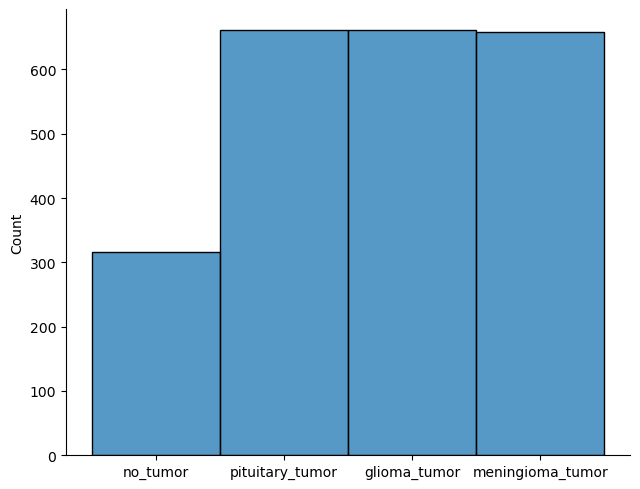

In [11]:
dist = sns.displot(y_train, kind="hist", height=5, aspect=1.3)
dist.savefig("traindata.jpg")

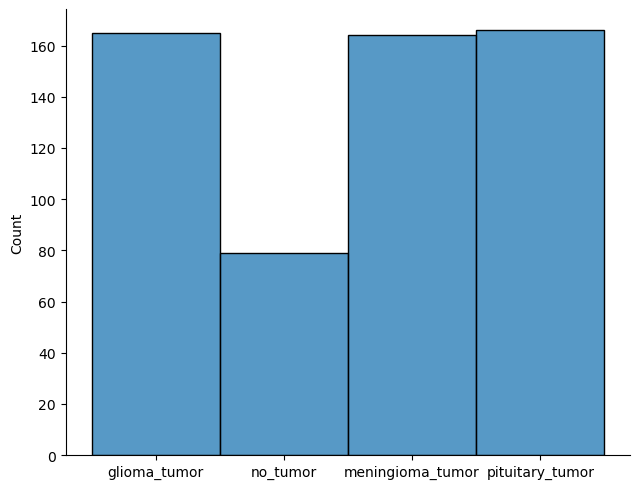

In [12]:
dist = sns.displot(y_val, kind="hist", height=5, aspect=1.3)
dist.savefig("valdata.jpg")

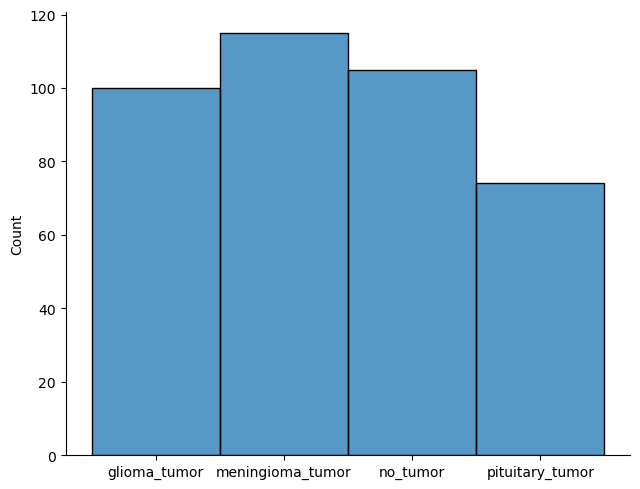

In [13]:
dist = sns.displot(y_test, kind="hist", height=5, aspect=1.3)
dist.savefig("testdata.jpg")

In [14]:
from imblearn.over_sampling import RandomOverSampler

X_reshaped = np.array(X_train).reshape(-1, 1)

ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_reshaped, y_train)
X_resampled = X_resampled.reshape(-1)
X_resampled

array([WindowsPath('data/Training/no_tumor/image(303).jpg'),
       WindowsPath('data/Training/pituitary_tumor/p (660).jpg'),
       WindowsPath('data/Training/glioma_tumor/gg (808).jpg'), ...,
       WindowsPath('data/Training/no_tumor/image(324).jpg'),
       WindowsPath('data/Training/no_tumor/image (26).jpg'),
       WindowsPath('data/Training/no_tumor/image(118).jpg')], dtype=object)

In [15]:
len(X_resampled), len(y_resampled)

(2644, 2644)

In [16]:
X_train, y_train = X_resampled, y_resampled

In [17]:
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(2644, 2644, 574, 574, 394, 394)

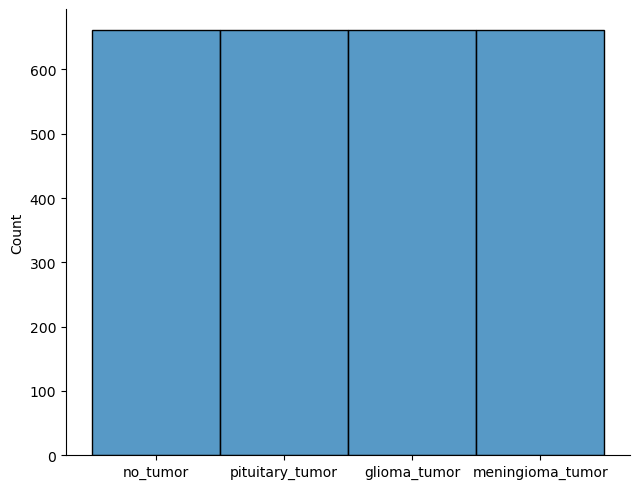

In [18]:
dist = sns.displot(y_train, kind="hist", height=5, aspect=1.3)
dist.savefig("oversampledtraindata.jpg")

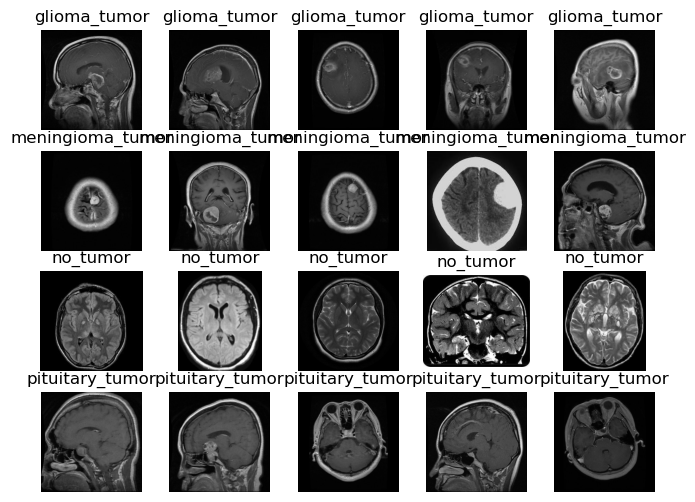

In [19]:
fig, axes = plt.subplots(4, 5, figsize=(8, 6))

for i, cls in enumerate(classes):
    imgs = list((Path("data/Training") / cls).glob("*"))
    for j in range(5):
        img = Image.open(choice(imgs))
        axes[i][j].set_title(cls)
        axes[i][j].imshow(img)
        axes[i][j].axis("off")

plt.savefig("sampleimages.jpg")

In [20]:
image_paths = np.concatenate((X_train, X_val, X_test))
len(image_paths)

3612

In [69]:
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image


def analyze_images(image_paths):
    stats = []
    for img_path in image_paths:
        img = Image.open(img_path)
        img_array = np.array(img)

        resolution = f"{img.size[0]}x{img.size[1]}"
        resolution_category = "512x512" if resolution == "512x512" else "Other"

        stat = {
            "filename": img_path.name,
            "mode": img.mode,
            "width": img.size[0],
            "height": img.size[1],
            "resolution": resolution,
            "resolution_category": resolution_category,
        }

        if img_array.size > 0:
            stat.update(
                {
                    "min_value": float(img_array.min()),
                    "max_value": float(img_array.max()),
                    "is_normalized": img_array.min() >= 0 and img_array.max() <= 255,
                }
            )
        stats.append(stat)

    df = pd.DataFrame(stats)

    summary = {
        "mode_counts": df["mode"].value_counts().to_dict(),
        "resolution_counts": df["resolution_category"].value_counts().to_dict(),
        "normalized_counts": {
            "Normalized": int(df["is_normalized"].sum()),
            "Not normalized": int((~df["is_normalized"]).sum()),
        },
    }

    return df, summary

In [22]:
df, summary = analyze_images(image_paths)

In [23]:
print("\nColor Mode Distribution:")
for mode, count in summary["mode_counts"].items():
    print(f"{mode}: {count} images")

print("\nResolution Distribution:")
for res, count in summary["resolution_counts"].items():
    print(f"{res}: {count} images")

print("\nNormalization Status:")
for status, count in summary["normalized_counts"].items():
    print(f"{status}: {count} images")


Color Mode Distribution:
RGB: 3612 images

Resolution Distribution:
512x512: 2349 images
Other: 1263 images

Normalization Status:
Normalized: 3612 images
Not normalized: 0 images


In [24]:
def sobelfilter(image, **kwargs):
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img_clahe = A.CLAHE(clip_limit=(1, 4), tile_grid_size=(8, 8), p=0.9)(
        image=gray_img
    )["image"]
    sobelx = cv2.Sobel(img_clahe, cv2.CV_64F, 1, 0, ksize=9)
    sobely = cv2.Sobel(img_clahe, cv2.CV_64F, 0, 1, ksize=9)
    edges = cv2.magnitude(sobelx, sobely)
    edges = cv2.normalize(edges, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    _, rib_mask = cv2.threshold(edges, 15, 255, cv2.THRESH_BINARY)
    return edges

In [73]:
transforms = A.Compose(
    [
        A.Resize(227, 227),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=45, p=0.5, border_mode=cv2.BORDER_DEFAULT),
        A.GaussianBlur(blur_limit=(3, 7), sigma_limit=(0.1, 2), p=1),
        A.CLAHE(clip_limit=(1, 4), tile_grid_size=(8, 8), p=1.0),
        A.Lambda(name="Sobel Filter", image=sobelfilter),
        A.ToRGB(),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
            max_pixel_value=255.0,
            p=1.0,
        ),
        ToTensorV2(),
    ]
)

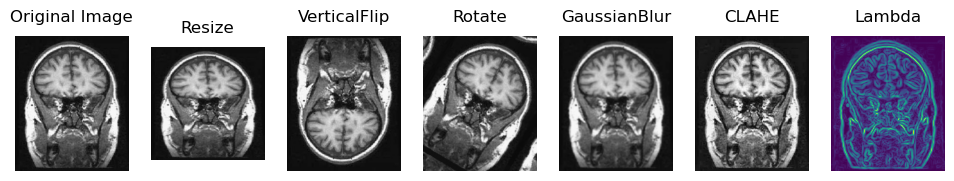

In [71]:
img = cv2.imread(X_train[0])

viz_transforms = A.Compose(
    [t for t in transforms if not isinstance(t, (A.ToRGB, A.Normalize, ToTensorV2))]
)
fig, axes = plt.subplots(1, len(viz_transforms) + 1, figsize=(12, 10))
axes[0].imshow(img)
axes[0].axis("off")
axes[0].set_title("Original Image", pad=10)
for i in range(1, len(viz_transforms) + 1):
    transformed_img = viz_transforms[i - 1](image=img)["image"]
    transform_name = viz_transforms[i - 1].__class__.__name__
    axes[i].set_title(transform_name, pad=10)
    axes[i].imshow(transformed_img)
    axes[i].axis("off")
plt.savefig("transforms.jpg")

In [27]:
from data_setup import create_dataloaders

train_dataloader, val_dataloader, test_dataloader = create_dataloaders(
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    transform=transforms,
    batch_size=128,
)

In [28]:
from model_builder import AlexNet
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=4)
model = model.to(device)
_ = summary(model)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       23,296
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       307,392
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       663,936
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       884,992
|    └─ReLU: 2-10                        --
|    └─Conv2d: 2-11                      590,080
|    └─ReLU: 2-12                        --
|    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
|    └─Dropout: 2-14                     --
|    └─Linear: 2-15                      37,752,832
|    └─ReLU: 2-16                        --
|    └─Dropout: 2-17                     --
|    └─Linear: 2-18                    

In [29]:
loss_fn = nn.CrossEntropyLoss(reduction="mean")

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=10
)

In [30]:
from engine import train

model, results = train(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=90,
    device=device,
    verbose=True,
)

  0%|                                                                                           | 0/90 [00:00<?, ?it/s]

Epoch 0/89, current lr=0.01


  1%|▉                                                                                  | 1/90 [00:20<30:52, 20.81s/it]

Copied best model weights!
train loss: 1.386667, val loss: 1.386743, accuracy: 30.04
----------
Epoch 1/89, current lr=0.01


  2%|█▊                                                                                 | 2/90 [00:40<29:30, 20.12s/it]

train loss: 1.386240, val loss: 1.387585, accuracy: 14.51
----------
Epoch 2/89, current lr=0.01


  3%|██▊                                                                                | 3/90 [01:00<28:58, 19.98s/it]

Copied best model weights!
train loss: 1.385683, val loss: 1.386440, accuracy: 14.17
----------
Epoch 3/89, current lr=0.01


  4%|███▋                                                                               | 4/90 [01:20<28:46, 20.07s/it]

Copied best model weights!
train loss: 1.384944, val loss: 1.385319, accuracy: 26.09
----------
Epoch 4/89, current lr=0.01


  6%|████▌                                                                              | 5/90 [01:41<28:41, 20.26s/it]

Copied best model weights!
train loss: 1.384481, val loss: 1.384783, accuracy: 24.96
----------
Epoch 5/89, current lr=0.01


  7%|█████▌                                                                             | 6/90 [02:01<28:23, 20.27s/it]

Copied best model weights!
train loss: 1.383457, val loss: 1.382512, accuracy: 24.22
----------
Epoch 6/89, current lr=0.01


  8%|██████▍                                                                            | 7/90 [02:21<28:00, 20.25s/it]

Copied best model weights!
train loss: 1.380523, val loss: 1.380437, accuracy: 23.42
----------
Epoch 7/89, current lr=0.01


  9%|███████▍                                                                           | 8/90 [02:41<27:44, 20.29s/it]

Copied best model weights!
train loss: 1.371252, val loss: 1.354757, accuracy: 35.51
----------
Epoch 8/89, current lr=0.01


 10%|████████▎                                                                          | 9/90 [03:02<27:26, 20.33s/it]

Copied best model weights!
train loss: 1.341708, val loss: 1.295583, accuracy: 40.31
----------
Epoch 9/89, current lr=0.01


 11%|█████████                                                                         | 10/90 [03:22<26:57, 20.22s/it]

Copied best model weights!
train loss: 1.281083, val loss: 1.224323, accuracy: 48.95
----------
Epoch 10/89, current lr=0.01


 12%|██████████                                                                        | 11/90 [03:42<26:37, 20.23s/it]

Copied best model weights!
train loss: 1.226586, val loss: 1.202346, accuracy: 50.16
----------
Epoch 11/89, current lr=0.01


 13%|██████████▉                                                                       | 12/90 [04:02<26:14, 20.19s/it]

Copied best model weights!
train loss: 1.146357, val loss: 1.084128, accuracy: 53.91
----------
Epoch 12/89, current lr=0.01


 14%|███████████▊                                                                      | 13/90 [04:22<25:56, 20.22s/it]

Copied best model weights!
train loss: 1.059075, val loss: 0.976411, accuracy: 59.31
----------
Epoch 13/89, current lr=0.01


 16%|████████████▊                                                                     | 14/90 [04:43<25:34, 20.19s/it]

Copied best model weights!
train loss: 1.028724, val loss: 0.971080, accuracy: 56.60
----------
Epoch 14/89, current lr=0.01


 17%|█████████████▋                                                                    | 15/90 [05:02<25:06, 20.09s/it]

train loss: 1.034224, val loss: 1.015542, accuracy: 54.52
----------
Epoch 15/89, current lr=0.01


 18%|██████████████▌                                                                   | 16/90 [05:23<24:46, 20.09s/it]

Copied best model weights!
train loss: 0.940845, val loss: 0.955749, accuracy: 62.65
----------
Epoch 16/89, current lr=0.01


 19%|███████████████▍                                                                  | 17/90 [05:43<24:33, 20.19s/it]

Copied best model weights!
train loss: 0.913902, val loss: 0.889261, accuracy: 64.13
----------
Epoch 17/89, current lr=0.01


 20%|████████████████▍                                                                 | 18/90 [06:03<24:11, 20.16s/it]

train loss: 0.844374, val loss: 0.950143, accuracy: 58.46
----------
Epoch 18/89, current lr=0.01


 21%|█████████████████▎                                                                | 19/90 [06:23<23:52, 20.17s/it]

Copied best model weights!
train loss: 0.859396, val loss: 0.849726, accuracy: 64.51
----------
Epoch 19/89, current lr=0.01


 22%|██████████████████▏                                                               | 20/90 [06:43<23:31, 20.16s/it]

train loss: 0.821592, val loss: 0.852657, accuracy: 61.51
----------
Epoch 20/89, current lr=0.01


 23%|███████████████████▏                                                              | 21/90 [07:04<23:17, 20.25s/it]

Copied best model weights!
train loss: 0.758663, val loss: 0.743918, accuracy: 68.39
----------
Epoch 21/89, current lr=0.01


 24%|████████████████████                                                              | 22/90 [07:24<22:51, 20.17s/it]

train loss: 0.762094, val loss: 0.835014, accuracy: 62.09
----------
Epoch 22/89, current lr=0.01


 26%|████████████████████▉                                                             | 23/90 [07:44<22:31, 20.17s/it]

Copied best model weights!
train loss: 0.792325, val loss: 0.728826, accuracy: 65.70
----------
Epoch 23/89, current lr=0.01


 27%|█████████████████████▊                                                            | 24/90 [08:04<22:12, 20.19s/it]

train loss: 0.705343, val loss: 0.777556, accuracy: 67.12
----------
Epoch 24/89, current lr=0.01


 28%|██████████████████████▊                                                           | 25/90 [08:25<21:59, 20.30s/it]

Copied best model weights!
train loss: 0.673427, val loss: 0.683856, accuracy: 68.26
----------
Epoch 25/89, current lr=0.01


 29%|███████████████████████▋                                                          | 26/90 [08:45<21:37, 20.27s/it]

train loss: 0.686793, val loss: 0.733064, accuracy: 70.03
----------
Epoch 26/89, current lr=0.01


 30%|████████████████████████▌                                                         | 27/90 [09:05<21:10, 20.17s/it]

train loss: 0.661053, val loss: 0.724031, accuracy: 68.90
----------
Epoch 27/89, current lr=0.01


 31%|█████████████████████████▌                                                        | 28/90 [09:25<20:53, 20.22s/it]

Copied best model weights!
train loss: 0.624239, val loss: 0.659028, accuracy: 72.92
----------
Epoch 28/89, current lr=0.01


 32%|██████████████████████████▍                                                       | 29/90 [09:45<20:32, 20.20s/it]

train loss: 0.641288, val loss: 0.685445, accuracy: 71.33
----------
Epoch 29/89, current lr=0.01


 33%|███████████████████████████▎                                                      | 30/90 [10:05<20:09, 20.16s/it]

train loss: 0.623155, val loss: 0.731302, accuracy: 66.89
----------
Epoch 30/89, current lr=0.01


 34%|████████████████████████████▏                                                     | 31/90 [10:26<19:54, 20.25s/it]

Copied best model weights!
train loss: 0.635324, val loss: 0.646384, accuracy: 72.97
----------
Epoch 31/89, current lr=0.01


 36%|█████████████████████████████▏                                                    | 32/90 [10:46<19:35, 20.27s/it]

train loss: 0.608533, val loss: 0.663793, accuracy: 71.82
----------
Epoch 32/89, current lr=0.01


 37%|██████████████████████████████                                                    | 33/90 [11:06<19:09, 20.18s/it]

train loss: 0.588869, val loss: 0.683972, accuracy: 73.27
----------
Epoch 33/89, current lr=0.01


 38%|██████████████████████████████▉                                                   | 34/90 [11:26<18:46, 20.11s/it]

train loss: 0.574868, val loss: 0.651928, accuracy: 72.48
----------
Epoch 34/89, current lr=0.01


 39%|███████████████████████████████▉                                                  | 35/90 [11:46<18:26, 20.12s/it]

train loss: 0.571398, val loss: 0.711206, accuracy: 69.87
----------
Epoch 35/89, current lr=0.01


 40%|████████████████████████████████▊                                                 | 36/90 [12:07<18:12, 20.24s/it]

Copied best model weights!
train loss: 0.561256, val loss: 0.630151, accuracy: 72.02
----------
Epoch 36/89, current lr=0.01


 41%|█████████████████████████████████▋                                                | 37/90 [12:27<17:50, 20.20s/it]

Copied best model weights!
train loss: 0.533533, val loss: 0.563848, accuracy: 75.96
----------
Epoch 37/89, current lr=0.01


 42%|██████████████████████████████████▌                                               | 38/90 [12:47<17:27, 20.14s/it]

train loss: 0.526551, val loss: 0.605664, accuracy: 73.80
----------
Epoch 38/89, current lr=0.01


 43%|███████████████████████████████████▌                                              | 39/90 [13:07<17:04, 20.10s/it]

train loss: 0.523432, val loss: 0.596178, accuracy: 74.56
----------
Epoch 39/89, current lr=0.01


 44%|████████████████████████████████████▍                                             | 40/90 [13:27<16:42, 20.05s/it]

train loss: 0.515728, val loss: 0.628747, accuracy: 76.16
----------
Epoch 40/89, current lr=0.01


 46%|█████████████████████████████████████▎                                            | 41/90 [13:46<16:14, 19.89s/it]

train loss: 0.502104, val loss: 0.580891, accuracy: 77.04
----------
Epoch 41/89, current lr=0.01


 47%|██████████████████████████████████████▎                                           | 42/90 [14:06<15:51, 19.82s/it]

train loss: 0.456594, val loss: 0.570278, accuracy: 75.29
----------
Epoch 42/89, current lr=0.01


 48%|███████████████████████████████████████▏                                          | 43/90 [14:26<15:26, 19.72s/it]

train loss: 0.487298, val loss: 0.581362, accuracy: 75.94
----------
Epoch 43/89, current lr=0.01


 49%|████████████████████████████████████████                                          | 44/90 [14:45<15:08, 19.75s/it]

train loss: 0.464838, val loss: 0.568504, accuracy: 79.05
----------
Epoch 44/89, current lr=0.01


 50%|█████████████████████████████████████████                                         | 45/90 [15:05<14:47, 19.73s/it]

train loss: 0.452044, val loss: 0.566136, accuracy: 76.54
----------
Epoch 45/89, current lr=0.01


 51%|█████████████████████████████████████████▉                                        | 46/90 [15:25<14:28, 19.75s/it]

Copied best model weights!
train loss: 0.411190, val loss: 0.549132, accuracy: 78.17
----------
Epoch 46/89, current lr=0.01


 52%|██████████████████████████████████████████▊                                       | 47/90 [15:45<14:10, 19.77s/it]

Copied best model weights!
train loss: 0.413659, val loss: 0.526474, accuracy: 78.17
----------
Epoch 47/89, current lr=0.01


 53%|███████████████████████████████████████████▋                                      | 48/90 [16:05<13:52, 19.81s/it]

train loss: 0.428784, val loss: 0.586876, accuracy: 76.89
----------
Epoch 48/89, current lr=0.01


 54%|████████████████████████████████████████████▋                                     | 49/90 [16:25<13:43, 20.09s/it]

Copied best model weights!
train loss: 0.427533, val loss: 0.513601, accuracy: 80.02
----------
Epoch 49/89, current lr=0.01


 56%|█████████████████████████████████████████████▌                                    | 50/90 [16:45<13:21, 20.03s/it]

train loss: 0.411907, val loss: 0.556939, accuracy: 77.06
----------
Epoch 50/89, current lr=0.01


 57%|██████████████████████████████████████████████▍                                   | 51/90 [17:05<13:01, 20.05s/it]

Copied best model weights!
train loss: 0.451482, val loss: 0.493955, accuracy: 79.88
----------
Epoch 51/89, current lr=0.01


 58%|███████████████████████████████████████████████▍                                  | 52/90 [17:26<12:46, 20.18s/it]

train loss: 0.416599, val loss: 0.534656, accuracy: 80.04
----------
Epoch 52/89, current lr=0.01


 59%|████████████████████████████████████████████████▎                                 | 53/90 [17:46<12:31, 20.32s/it]

Copied best model weights!
train loss: 0.382355, val loss: 0.482041, accuracy: 80.21
----------
Epoch 53/89, current lr=0.01


 60%|█████████████████████████████████████████████████▏                                | 54/90 [18:07<12:11, 20.31s/it]

train loss: 0.381435, val loss: 0.572106, accuracy: 78.94
----------
Epoch 54/89, current lr=0.01


 61%|██████████████████████████████████████████████████                                | 55/90 [18:27<11:46, 20.19s/it]

train loss: 0.378791, val loss: 0.537243, accuracy: 80.99
----------
Epoch 55/89, current lr=0.01


 62%|███████████████████████████████████████████████████                               | 56/90 [18:46<11:23, 20.10s/it]

train loss: 0.397282, val loss: 0.581173, accuracy: 76.71
----------
Epoch 56/89, current lr=0.01


 63%|███████████████████████████████████████████████████▉                              | 57/90 [19:06<11:00, 20.03s/it]

train loss: 0.383212, val loss: 0.491547, accuracy: 80.05
----------
Epoch 57/89, current lr=0.01


 64%|████████████████████████████████████████████████████▊                             | 58/90 [19:27<10:44, 20.14s/it]

Copied best model weights!
train loss: 0.366594, val loss: 0.476128, accuracy: 80.99
----------
Epoch 58/89, current lr=0.01


 66%|█████████████████████████████████████████████████████▊                            | 59/90 [19:47<10:22, 20.09s/it]

train loss: 0.350230, val loss: 0.492786, accuracy: 80.21
----------
Epoch 59/89, current lr=0.01


 67%|██████████████████████████████████████████████████████▋                           | 60/90 [20:08<10:09, 20.31s/it]

train loss: 0.368335, val loss: 0.582422, accuracy: 80.82
----------
Epoch 60/89, current lr=0.01


 68%|███████████████████████████████████████████████████████▌                          | 61/90 [20:28<09:46, 20.22s/it]

train loss: 0.347686, val loss: 0.541675, accuracy: 78.63
----------
Epoch 61/89, current lr=0.01


 69%|████████████████████████████████████████████████████████▍                         | 62/90 [20:48<09:27, 20.28s/it]

train loss: 0.336201, val loss: 0.518327, accuracy: 81.30
----------
Epoch 62/89, current lr=0.01


 70%|█████████████████████████████████████████████████████████▍                        | 63/90 [21:08<09:03, 20.14s/it]

train loss: 0.329572, val loss: 0.513397, accuracy: 80.33
----------
Epoch 63/89, current lr=0.01


 71%|██████████████████████████████████████████████████████████▎                       | 64/90 [21:28<08:45, 20.20s/it]

train loss: 0.345161, val loss: 0.492374, accuracy: 80.50
----------
Epoch 64/89, current lr=0.01


 72%|███████████████████████████████████████████████████████████▏                      | 65/90 [21:48<08:24, 20.19s/it]

train loss: 0.306116, val loss: 0.501093, accuracy: 80.67
----------
Epoch 65/89, current lr=0.01


 73%|████████████████████████████████████████████████████████████▏                     | 66/90 [22:10<08:13, 20.58s/it]

Copied best model weights!
train loss: 0.323628, val loss: 0.444155, accuracy: 81.26
----------
Epoch 66/89, current lr=0.01


 74%|█████████████████████████████████████████████████████████████                     | 67/90 [22:30<07:52, 20.54s/it]

train loss: 0.309694, val loss: 0.487913, accuracy: 81.60
----------
Epoch 67/89, current lr=0.01


 76%|█████████████████████████████████████████████████████████████▉                    | 68/90 [22:51<07:30, 20.46s/it]

train loss: 0.328712, val loss: 0.464555, accuracy: 81.44
----------
Epoch 68/89, current lr=0.01


 77%|██████████████████████████████████████████████████████████████▊                   | 69/90 [23:12<07:13, 20.67s/it]

train loss: 0.301196, val loss: 0.508939, accuracy: 81.09
----------
Epoch 69/89, current lr=0.01


 78%|███████████████████████████████████████████████████████████████▊                  | 70/90 [23:32<06:51, 20.59s/it]

train loss: 0.293849, val loss: 0.467212, accuracy: 79.87
----------
Epoch 70/89, current lr=0.01


 79%|████████████████████████████████████████████████████████████████▋                 | 71/90 [23:53<06:33, 20.71s/it]

train loss: 0.299069, val loss: 0.464454, accuracy: 79.55
----------
Epoch 71/89, current lr=0.01


 80%|█████████████████████████████████████████████████████████████████▌                | 72/90 [24:14<06:11, 20.66s/it]

train loss: 0.286418, val loss: 0.511166, accuracy: 80.18
----------
Epoch 72/89, current lr=0.01


 81%|██████████████████████████████████████████████████████████████████▌               | 73/90 [24:34<05:51, 20.67s/it]

train loss: 0.301261, val loss: 0.464631, accuracy: 80.79
----------
Epoch 73/89, current lr=0.01


 82%|███████████████████████████████████████████████████████████████████▍              | 74/90 [24:55<05:29, 20.61s/it]

Copied best model weights!
train loss: 0.312051, val loss: 0.413435, accuracy: 82.68
----------
Epoch 74/89, current lr=0.01


 83%|████████████████████████████████████████████████████████████████████▎             | 75/90 [25:15<05:07, 20.51s/it]

train loss: 0.319932, val loss: 0.515229, accuracy: 80.47
----------
Epoch 75/89, current lr=0.01


 84%|█████████████████████████████████████████████████████████████████████▏            | 76/90 [25:37<04:51, 20.82s/it]

train loss: 0.297785, val loss: 0.489822, accuracy: 81.43
----------
Epoch 76/89, current lr=0.01


 86%|██████████████████████████████████████████████████████████████████████▏           | 77/90 [25:58<04:31, 20.86s/it]

train loss: 0.302091, val loss: 0.427318, accuracy: 82.86
----------
Epoch 77/89, current lr=0.01


 87%|███████████████████████████████████████████████████████████████████████           | 78/90 [26:18<04:09, 20.78s/it]

train loss: 0.265545, val loss: 0.461796, accuracy: 82.27
----------
Epoch 78/89, current lr=0.01


 88%|███████████████████████████████████████████████████████████████████████▉          | 79/90 [26:39<03:50, 20.93s/it]

Copied best model weights!
train loss: 0.276146, val loss: 0.401113, accuracy: 84.63
----------
Epoch 79/89, current lr=0.01


 89%|████████████████████████████████████████████████████████████████████████▉         | 80/90 [26:59<03:26, 20.67s/it]

train loss: 0.245949, val loss: 0.446662, accuracy: 82.91
----------
Epoch 80/89, current lr=0.01


 90%|█████████████████████████████████████████████████████████████████████████▊        | 81/90 [27:20<03:05, 20.57s/it]

train loss: 0.233966, val loss: 0.527371, accuracy: 79.53
----------
Epoch 81/89, current lr=0.01


 91%|██████████████████████████████████████████████████████████████████████████▋       | 82/90 [27:40<02:43, 20.48s/it]

train loss: 0.249958, val loss: 0.490035, accuracy: 82.67
----------
Epoch 82/89, current lr=0.01


 92%|███████████████████████████████████████████████████████████████████████████▌      | 83/90 [28:01<02:23, 20.57s/it]

train loss: 0.251402, val loss: 0.455215, accuracy: 83.46
----------
Epoch 83/89, current lr=0.01


 93%|████████████████████████████████████████████████████████████████████████████▌     | 84/90 [28:21<02:03, 20.55s/it]

train loss: 0.254816, val loss: 0.410647, accuracy: 83.52
----------
Epoch 84/89, current lr=0.01


 94%|█████████████████████████████████████████████████████████████████████████████▍    | 85/90 [28:42<01:42, 20.43s/it]

train loss: 0.263932, val loss: 0.490030, accuracy: 84.06
----------
Epoch 85/89, current lr=0.01


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 86/90 [29:02<01:21, 20.44s/it]

Copied best model weights!
train loss: 0.262881, val loss: 0.398513, accuracy: 83.97
----------
Epoch 86/89, current lr=0.01


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 87/90 [29:23<01:01, 20.52s/it]

train loss: 0.229100, val loss: 0.448747, accuracy: 80.52
----------
Epoch 87/89, current lr=0.01


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 88/90 [29:43<00:41, 20.52s/it]

train loss: 0.230487, val loss: 0.419312, accuracy: 84.26
----------
Epoch 88/89, current lr=0.01


 99%|█████████████████████████████████████████████████████████████████████████████████ | 89/90 [30:04<00:20, 20.48s/it]

Copied best model weights!
train loss: 0.228095, val loss: 0.386081, accuracy: 85.53
----------
Epoch 89/89, current lr=0.01


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [30:24<00:00, 20.27s/it]

train loss: 0.236439, val loss: 0.466130, accuracy: 82.58
----------


In [31]:
from utils import save_model

save_model(model=model, target_dir="models", model_name="AlexNet.pth")

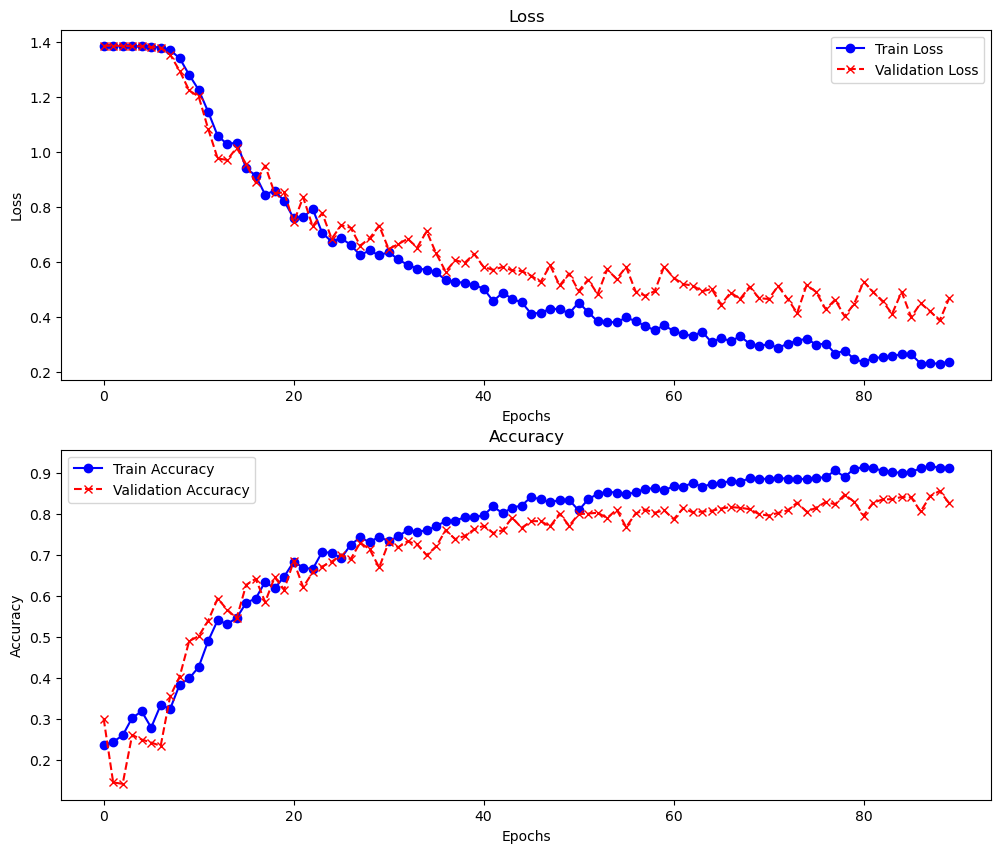

In [32]:
epochs = range(90)

fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].plot(
    epochs,
    results["train_loss"],
    label="Train Loss",
    color="blue",
    linestyle="-",
    marker="o",
)
ax[0].plot(
    epochs,
    results["val_loss"],
    label="Validation Loss",
    color="red",
    linestyle="--",
    marker="x",
)
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(
    epochs,
    results["train_acc"],
    label="Train Accuracy",
    color="blue",
    linestyle="-",
    marker="o",
)
ax[1].plot(
    epochs,
    results["val_acc"],
    label="Validation Accuracy",
    color="red",
    linestyle="--",
    marker="x",
)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.savefig("results.jpg")

Test Accuracy: 0.7324
F1 Score: 0.6523
Precision: 0.6523
Recall: 0.6523


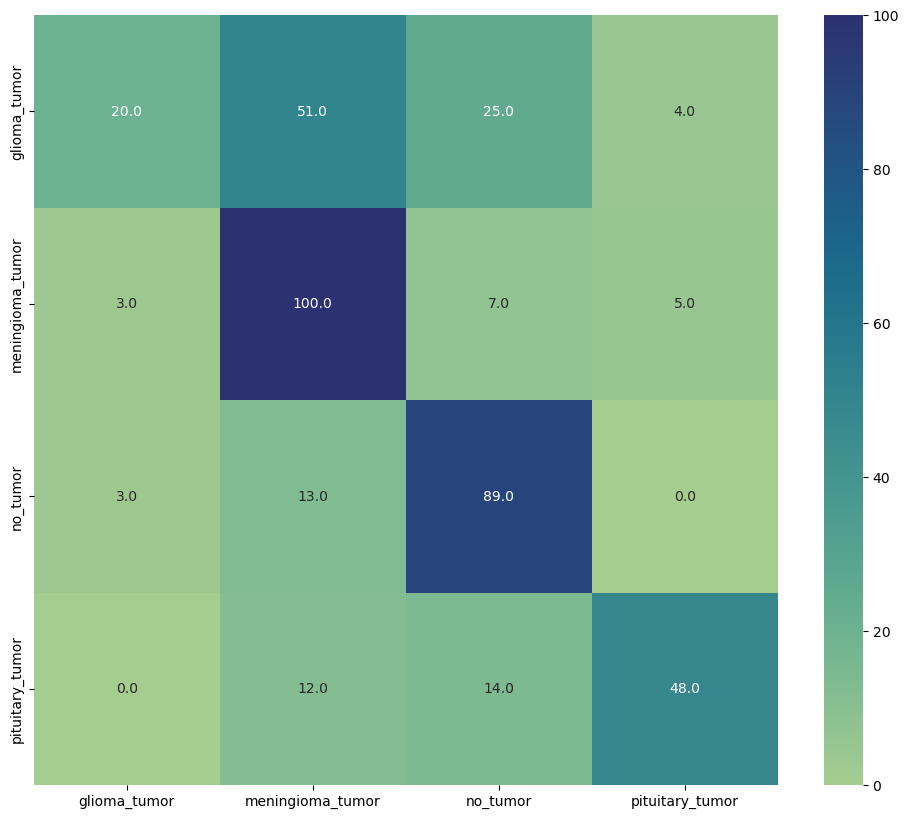

In [33]:
from torcheval.metrics.functional import (
    multiclass_confusion_matrix,
    multiclass_f1_score,
    multiclass_precision,
    multiclass_recall,
)

model = AlexNet(num_classes=4)
model.load_state_dict(torch.load("models/AlexNet.pth", weights_only=True))
model = model.to(device)
model.eval()

test_loss, test_acc = 0, 0

preds = []
labels = []

with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y.to(device)

        test_pred_logits = model(X)

        loss = loss_fn(test_pred_logits, y)

        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

        preds.append(test_pred_labels)
        labels.append(y)

    preds = torch.cat(preds)
    labels = torch.cat(labels)

    test_acc = test_acc / len(test_dataloader)

    conf_matrix = multiclass_confusion_matrix(preds, labels, num_classes=4)
    f1 = multiclass_f1_score(preds, labels, num_classes=4)
    precision = multiclass_precision(preds, labels, num_classes=4)
    recall = multiclass_recall(preds, labels, num_classes=4)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
plt.figure(figsize=(12, 10))

sns.heatmap(
    conf_matrix.cpu().numpy(),
    annot=True,
    fmt=".1f",
    cmap="crest",
    xticklabels=classes,
    yticklabels=classes,
)

plt.savefig("confusionmatrix.jpg")